## Tutorial on chemical reaction network (CRN) inference

Dependecies: `Catalyst, OrdinaryDiffEq, CairoMakie, Colors, Optim, LineSearches`

### Simulating a CRN

Fisrt, we simulate a synthetic dataset based on the following CRN, i.e. our ground-truth CRN:
$$ X_1\xrightarrow[]{k_{1}}X_2, \qquad X_1+X_2\xrightleftharpoons[k_{13}]{k_{18}}X_3.$$
The subscripts of the reaction rate constants will be explained later when we introduce the library CRN.

The `@reaction_network` macro from `Catalyst.jl` enables us to programatically define CRNs. Note that package imports and first calls to functions take longer times to run due to compilation.

In [1]:
using Catalyst

In [2]:
true_crn = @reaction_network begin
	k₁, X₁ --> X₂                # irreversible reaction
	(k₁₈, k₁₃), X₁ + X₂ <--> X₃	 # reversible reaction
end

Model ##ReactionSystem#236:
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

`Catalyst.jl` features functionality to automatically derive the corresponding ordinary differential equation (ODE) system (assuming mass-action kinetics).

In [3]:
convert(ODESystem, true_crn)

Model ##ReactionSystem#236:
Equations (3):
  3 standard: see equations(##ReactionSystem#236)
Unknowns (3): see unknowns(##ReactionSystem#236)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (3): see parameters(##ReactionSystem#236)
  k₁
  k₁₈
  k₁₃

$X_i(t)$ denotes the concentration of species $X_i$ at time $t$. To simulate the dynamics of this ODE system, say over $t\in[0,10]$, we need to define and solve an `ODEProblem`. We will use the initial values $(X_1(0), X_2(0), X_3(0)) = (0,0,1)$ and set the reaction rate constants as $(k_{1},k_{13},k_{18})=(1,1,1)$.

In [4]:
using OrdinaryDiffEq

In [5]:
t_span = (0., 10.) # time interval to solve on
x0map = [:X₁ => 0., :X₂ => 0., :X₃ => 1.] # initial conditions
true_kmap  = (:k₁ => 1., :k₁₈ => 1., :k₁₃ => 1.) # ground-truth reaction rate constants

true_oprob = ODEProblem(true_crn, x0map, t_span, true_kmap)
true_sol = solve(true_oprob)

retcode: Success
Interpolation: 3rd order Hermite
t: 25-element Vector{Float64}:
  0.0
  0.0007064002045583837
  0.00777040225014222
  0.06315968433324934
  0.1928699846865976
  0.36423312918202805
  0.5615034713530583
  0.79145734935309
  1.0488720148516424
  1.3403529510999195
  1.669938434997888
  2.0510666649383342
  2.5207107293442714
  3.0564329842106215
  3.561926125860312
  4.13136698482351
  4.714760215275044
  5.346194682853374
  6.00429719846049
  6.700607279215679
  7.426351301223158
  8.183870090671803
  8.969223219783037
  9.780867179274527
 10.0
u: 25-element Vector{Vector{Float64}}:
 [0.0, 0.0, 1.0]
 [0.0007059012621207238, 0.000706400028394102, 0.9992938493547426]
 [0.00771010220425349, 0.007770168881821247, 0.9922598644569627]
 [0.0592164565262739, 0.06303905903105121, 0.9388722422213375]
 [0.15719382861586914, 0.18975048507473566, 0.8265278431546976]
 [0.2434421842392797, 0.3459354671217682, 0.7053111743194761]
 [0.2947382093072657, 0.5048311193098635, 0.600215335691

Next, we extract the ODE solution at $101$ equally-spaced time points `t_obs`. Note that `true_sol(t_obs).u` is a vector of vectors (one vector per time point). We concatenate these vectors into a matrix (one column per time point).

In [6]:
n_obs = 101
t_obs = range(t_span..., n_obs)
data_noiseless = reduce(hcat, true_sol(t_obs).u)

3×101 Matrix{Float64}:
 0.0  0.0901911  0.16171   0.216322  …  0.0135083  0.0131308  0.0127647
 0.0  0.0995337  0.196541  0.28922      1.91539    1.91768    1.9199
 1.0  0.905138   0.820874  0.747229     0.0355485  0.0345941  0.0336656

To simulate noisy data, we introduce additive normal noise (independently and identically distributed) with standard deviation $\sigma=0.01$, and clamp the values to be nonnegative.

In [7]:
using Random
Random.seed!(1) # for reproducibility

σ = 0.01
data = data_noiseless .+ σ .* randn(size(data_noiseless)) # additive normal noise
data = max.(data, 0) # clamp negative values to 0

3×101 Matrix{Float64}:
 0.000619327  0.0906577  0.16347   …  0.0281459  0.0285949  0.00884948
 0.00278406   0.110392   0.205195     1.90582    1.91184    1.92575
 0.994042     0.889372   0.792972     0.0452687  0.0392716  0.0333524

We plot the noisy data along with the groud-truth trajectories. To plot the trajectories, we extract the ODE solution for a dense grid of timepoints. 

In [8]:
# Plotting setup
using CairoMakie
using Colors
set_theme!(theme_latexfonts());
update_theme!(
	Axis=(;
		xgridvisible=false, ygridvisible=false,
		xlabelsize=16, ylabelsize=16,
		titlesize=16,
	),
)
palette = Makie.wong_colors();
lighten(c, w) = RGB((1 .- (1 .- [c.r, c.g, c.b]).*w)...); # lighten color c (w=0 gives white)

In [9]:
# extract ODE solution for dense grid
t_grid = range(t_span..., 1001);
true_sol_grid = true_sol(t_grid);

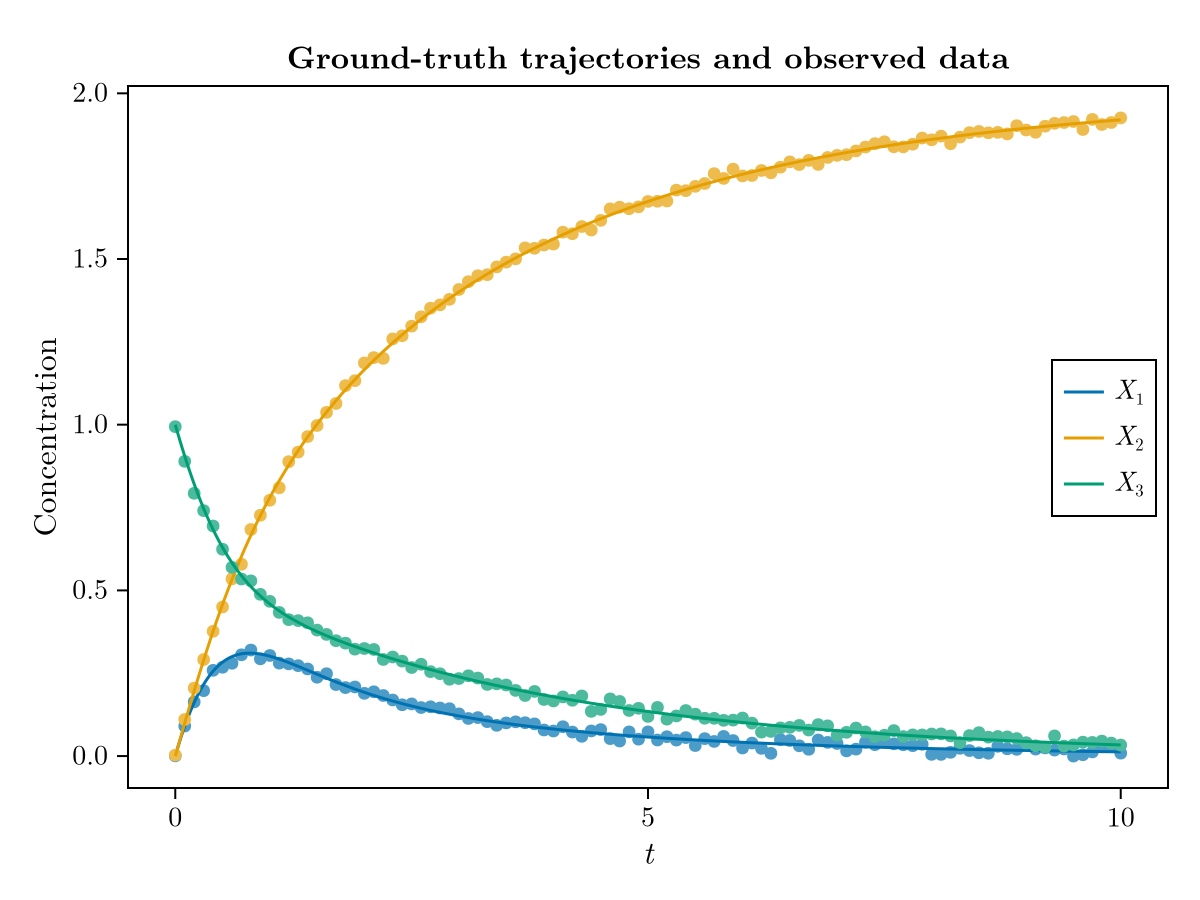

In [10]:
f = Figure()
ax = Axis(f[1,1], xlabel=L"$t$", ylabel="Concentration", title="Ground-truth trajectories and observed data")
n_species = size(data, 1)
for i in 1:n_species
    scatter!(t_obs, data[i,:], color=lighten(palette[i], 0.7))
    lines!(t_grid, [pt[i] for pt in true_sol_grid.u], label=L"$X_%$i$") # `L` parses the string as LaTeX, `%$i` substitutes the value of `i`
end
axislegend(position=:rc);
current_figure()

### Standard parameter inference

When investigating a system such as a CRN, simulating data from its ODEs is considered to be a *forward problem*; that is, to produce observations based on a parameterised model of the investigated system. The *inverse problem* involves inferring or estimating the values of the model parameters using observations of the system. For CRNs, the standard inverse problem is to infer the rate constants from observed data, where the **reactions are assumed to be known**. One approach to this inverse problem is to find the rate constants that minimise a loss function that quantifies the discrepancy between the predictions based on those rate constants and the observed data. Here, we use the sum of squared errors in our loss function, while assuming that the initial state $(X_1(0), X_2(0), X_3(0)) = (0,0,1)$ is known.

In [11]:
function loss_func_known_rx(rate_consts)
	oprob = remake(true_oprob, p=(:k₁ => rate_consts[1], :k₁₈ => rate_consts[2], :k₁₃ => rate_consts[3])); 
	sol = try 
		solve(oprob, saveat=t_obs); # simulate the ODE
	catch e
		return Inf # return Inf if the ODE simulation diverges
	end
	sum(abs2.(data .- reduce(hcat, sol.u))) / (2*σ^2)
end

loss_func_known_rx (generic function with 1 method)

Note that the sum of squared errors is divided by $2\sigma^2$, which is taken from the log-density of a normal distribution. We assume that the value of $\sigma$ is known during inference.

In [12]:
loss_func_known_rx([1,1,1]) # small loss value for ground-truth rate constants

167.55051233957516

In [13]:
loss_func_known_rx([0,0,0]) # large loss value for rate constants far from ground truth

1.5751597668722095e6

To obtain estimates of the rate constants, we minimise the loss function using the [BFGS algorithm](https://julianlsolvers.github.io/Optim.jl/stable/algo/lbfgs/), which is based on the first derivatives of the loss function. We have arbitrarily set lower and upper bounds for the rate constants at $k_min=10^{-10}$ and $k_max=10^{2}$ respectively, and start the optimisation process with random guesses (between $0$ and $1$) for the rate constants.

In [14]:
using Optim
using LineSearches
opt_args = (
    Fminbox(BFGS(linesearch = LineSearches.BackTracking())), # optimisation algorithm
    Optim.Options(x_abstol=1e-10, f_abstol=1e-10, outer_x_abstol=1e-10, outer_f_abstol=1e-10) # optimisation options
);

In [15]:
struct FunctionWrapper
    f::Function
end
(wrapper::FunctionWrapper)(arg) = wrapper.f(arg);

In [16]:
Random.seed!(2) # for reproducibility

n_true_rx = length(true_kmap)
# bounds for rate constants
LB = 1e-10; UB = 1e2;
lower_bounds = LB .* ones(n_true_rx)
upper_bounds = UB .* ones(n_true_rx)
# initial guess for rate constants (guess between 0 and 1)
start_pt = rand(n_true_rx)

res = optimize(FunctionWrapper(loss_func_known_rx), lower_bounds, upper_bounds, start_pt, opt_args...; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.673529e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 1.87e-14 ≤ 1.0e-10
    |x - x'|/|x'|          = 1.08e-14 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.10e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    3
    f(x) calls:    96
    ∇f(x) calls:   62


We check that the inferred rate constants, i.e. the rate constants which minimise the loss function, have values close to the ground truth $(k_{1},k_{13},k_{18})=(1,1,1)$.

In [17]:
res.minimizer

3-element Vector{Float64}:
 0.998772044692674
 0.9951018367251285
 0.9970354572004372

In practice, rate constants can vary over multiple scales across the reactions. It is therefore [recommended for optimisation to be performed at a log scale](https://doi.org/10.1093/bioinformatics/bty736), as we show below. We take the exponential of the optimised solution to transform it back to original scale of rate constants.

In [18]:
loss_func_known_rx_exp(θ) = loss_func_known_rx(exp.(θ)) # exp undoes the log transformation
res = optimize(FunctionWrapper(loss_func_known_rx_exp), log.(lower_bounds), log.(upper_bounds), log.(start_pt), opt_args...; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.673529e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 1.03e-15 ≤ 1.0e-10
    |x - x'|/|x'|          = 1.76e-13 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.35e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    5
    f(x) calls:    159
    ∇f(x) calls:   53


In [19]:
exp.(res.minimizer)

3-element Vector{Float64}:
 0.9987692938005213
 0.9950738567571032
 0.9970299441686312

### Defining a library CRN for structural inference

But what if the set of **reactions in the CRN are unknown**? Here, we come to an inverse problem concerning the *structure* of a model. Instead of assuming knowledge of the precise set of reactions involved in the system, we specify a set of *candidate reactions*, a small subset of which we assume are able to satisfactorily explain the observed data. We call the CRN formed by all candidate reactions the *library CRN*. For this tutorial, the reactants and products of each reaction are one of the complexes $\{X_1,X_2,X_3,X_1+X_2,X_2+X_3,X_1+X_3\}$ must be distinct. This results in $6\times 5=30$ candidate reactions. Instead of using the `@reaction_network` macro, here we [build a `ReactionSystem` programmatically](https://docs.sciml.ai/Catalyst/stable/model_creation/programmatic_CRN_construction/), which requires us to manually define the independent variable (time), the species, and the vector of reactions along with the rate constants as parameters.

In [20]:
t = default_t(); # time variable
xs = @species X₁(t) X₂(t) X₃(t)

complexes_vec = [xs[idx_vec] for idx_vec in [[1], [2], [3], [1, 2], [2, 3], [1, 3]]]; # all possible complexes
# define all ordered pairs of distinct complexes for reactions
rct_prd_pairs = [
	(reactants, products) for reactants in complexes_vec for products in complexes_vec 
	if reactants !== products
];
n_rx = length(rct_prd_pairs); # number of reactions
@parameters k[1:n_rx] # reaction rate constants
rx_vec = [
	Reaction(kval, reactants, products) for ((reactants, products), kval) in zip(rct_prd_pairs, k)
];

@named lib_crn = ReactionSystem(rx_vec, t, xs, k) # library CRN
lib_crn = complete(lib_crn) # `lib_crn` is defined using the `ReactionSystem` constructor, and so has to be manually marked as complete

Model lib_crn:
Unknowns (3): see unknowns(lib_crn)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(lib_crn)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

Bonus: The `Latexify` package produces LaTeX strings from Julia objects. Displaying the LaTeX results in Jupyter notebooks renders it (like the cell above), printing it produces the raw strings (see suppressed cell below).

In [21]:
using Latexify
print(latexify(lib_crn))

\begin{align*}
\require{mhchem} 
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{1}} \mathrm{\mathtt{X_2}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{2}} \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{3}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_2}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{4}} \mathrm{\mathtt{X_2}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_1}} &\xrightarrow{k_{5}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{6}} \mathrm{\mathtt{X_1}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{7}} \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{8}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_2}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{9}} \mathrm{\mathtt{X_2}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_2}} &\xrightarrow{k_{10}} \mathrm{\mathtt{X_1}} + \mathrm{\mathtt{X_3}} \\
\mathrm{\mathtt{X_3}} &\xrightarrow{k_{11}} \mathrm{\mathtt{X_1}} \\
\mathrm{\mathtt{X_3}} &\xrightarrow{k_{12}} \mathrm{\mathtt{X_2}} \\
\mat

### Parameter estimation for the library CRN

To infer the set of reactions present in the system, we seek to estimate the rate constants of all reactions of the library CRN, with prior knowledge that most of these rate constants are zero. To this end, we minimise an objective function that is the sum of our original loss function and a penalty function that increases with the rate constants. Similar to [Hoffmann et al. (2019)](https://doi.org/10.1063/1.5066099), we use an $L_1$ penalty, i.e. each rate constant $k$ incurs a penalty of $\lambda k$ for some hyperparameter $\lambda$.

In [22]:
# create ODEProblem corresponding to the library CRN
lib_oprob = ODEProblem(lib_crn, x0map, t_span, zeros(n_rx));

function loss_func_unknown_rx(rate_consts)
    # `k` is the variable name defined along with the library CRN
	oprob = remake(lib_oprob, p=[k => rate_consts]);
	sol = try 
		solve(oprob, saveat=t_obs); # simulate the ODE
	catch e
		return Inf # return Inf if the ODE simulation diverges
	end
	sum(abs2.(data .- reduce(hcat, sol.u))) / (2*σ^2)
end

λ = 1.0 # penalty hyperparameter
# we optimise on log space, so θ = log k
penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λ*sum(exp.(θ))

penalised_func (generic function with 1 method)

In [23]:
# sanity check for `penalised_func`
true_kvec = zeros(n_rx);
true_kvec[1] = true_kvec[13] = true_kvec[18] = 1.
penalised_func(log.(true_kvec))

170.55051233957516

In [24]:
Random.seed!(3) # for reproducibility

# bounds for log rate constants
lower_bounds = log.(LB .* ones(n_rx))
upper_bounds = log.(UB .* ones(n_rx))
# initial guesses for log rate constants (guess between 0 and 1)
n_start = 15
start_pt = log.(rand(n_rx))

res = optimize(FunctionWrapper(penalised_func), lower_bounds, upper_bounds, start_pt, opt_args...; autodiff = :forward)

 * Status: success

 * Candidate solution
    Final objective value:     1.646268e+02

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 4.08e-17 ≤ 1.0e-10
    |x - x'|/|x'|          = 8.39e-19 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 1.0e-10
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.58e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   40  (vs limit Inf)
    Iterations:    4
    f(x) calls:    746
    ∇f(x) calls:   542


To check if the optimisation result is sensible, we reconstruct ODE trajectories from the optimisation solution, and compare them to the ground truth trajectories.

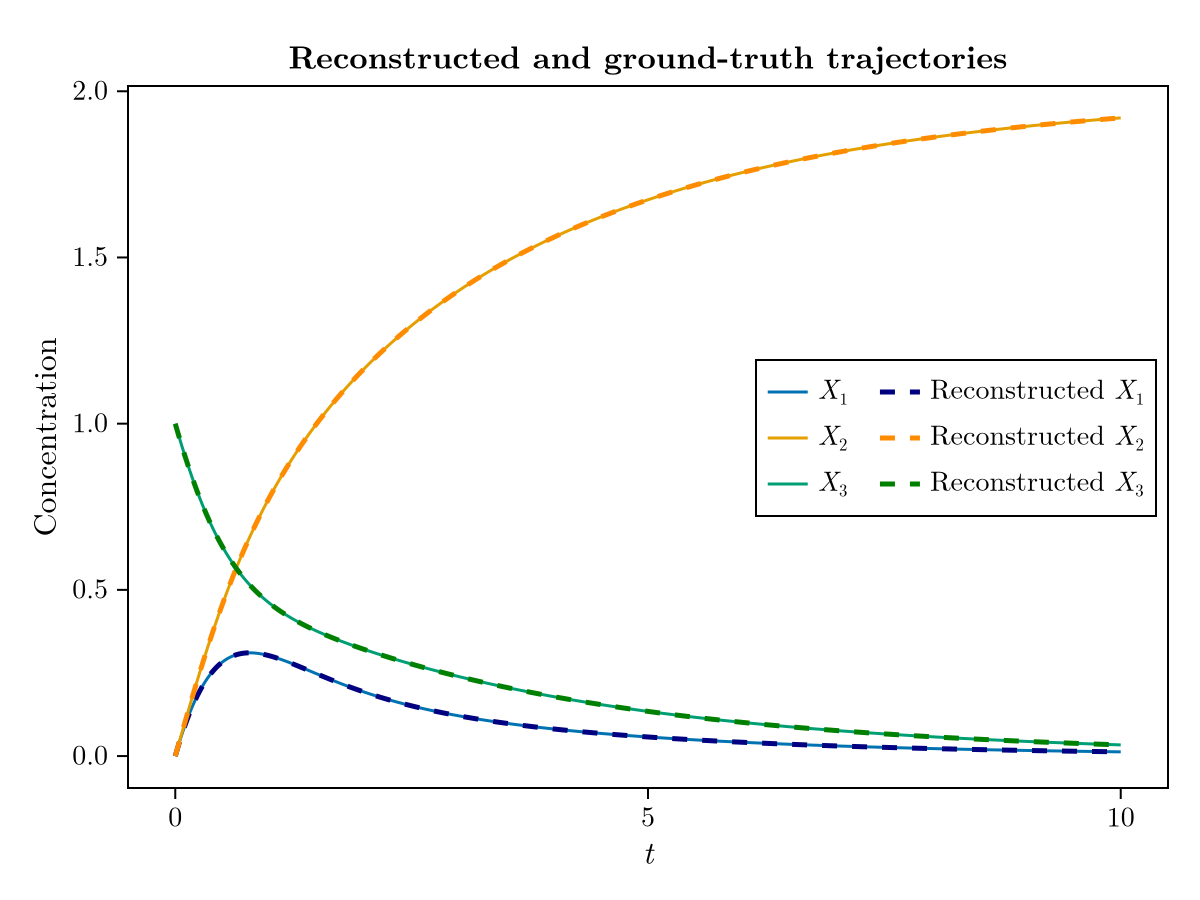

In [25]:
f = Figure()
ax = Axis(f[1,1], xlabel=L"$t$", ylabel="Concentration", title="Reconstructed and ground-truth trajectories")
est_kvec = exp.(res.minimizer)
recon_oprob = remake(lib_oprob, p=[k => est_kvec])
recon_sol_grid = solve(recon_oprob)(t_grid)
for i in 1:n_species
    lines!(t_grid, [pt[i] for pt in true_sol_grid.u], label=L"$X_%$i$", color=palette[i])
    lines!(
        t_grid, [pt[i] for pt in true_sol_grid.u], label=L"Reconstructed $X_%$i$", 
        color=[:navy, :darkorange, :green][i], linestyle=:dash, linewidth=2.5
    )
end
axislegend(position=:rc, nbanks=2);
current_figure()

The reconstructed trajectories resembles the ground truth well, so we move on to validating the rate constant estimates. Again, we compare the estimated rate constants with the ground truth. 

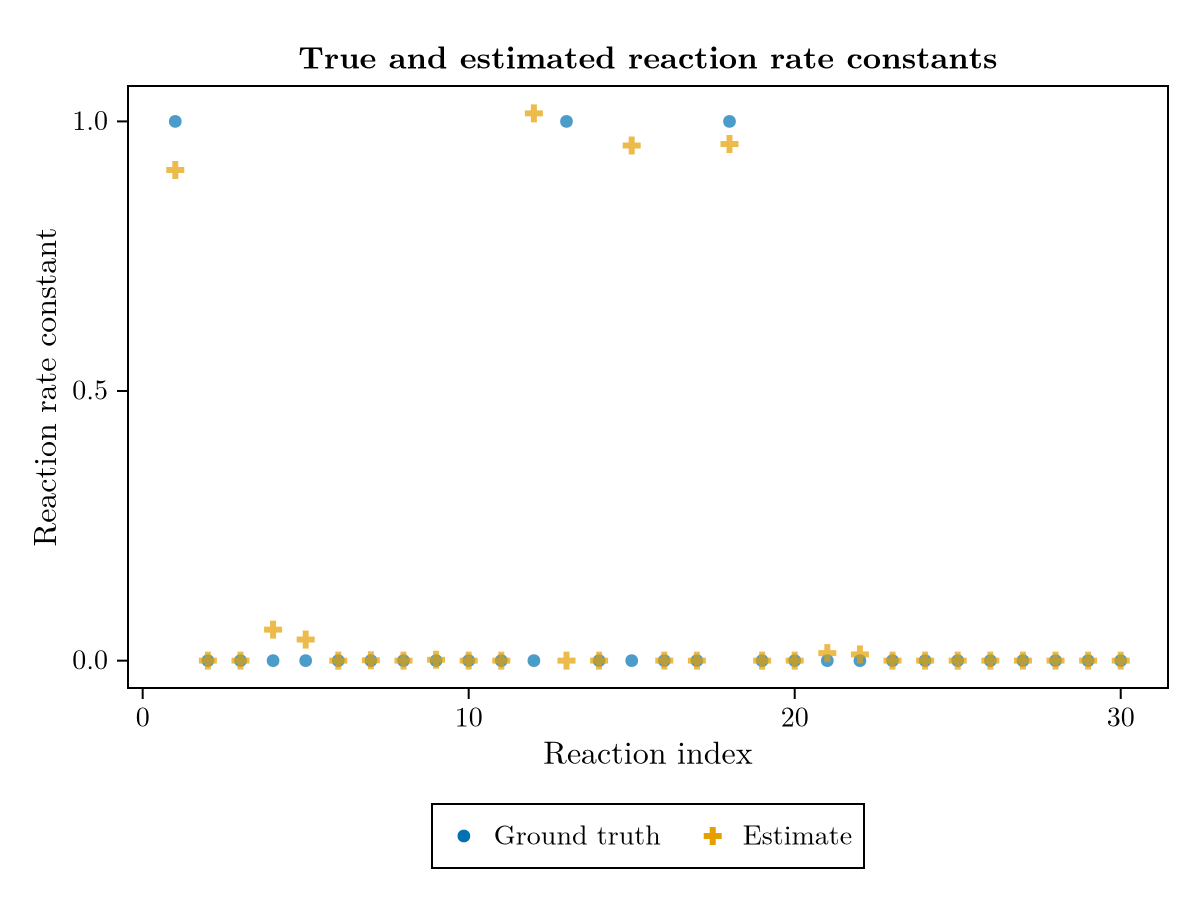

In [26]:
f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, est_kvec, alpha=0.7, label="Estimate", marker=:cross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

The rate constants for reactions $1$ and $18$ are underestimated, but reaction $13$ is missed by our inference procedure. We refer to this as a *false negative*. Instead, reactions $12$ and $15$ have rate constant estimates close to $1$, which corresponds to *false positives*. Our inferred CRN is different from the ground truth, yet the trajectories are reconstructed closely. This reflects a non-identifiability issue known as *dynamical equivalence*.

In [27]:
@named crn_13_only = ReactionSystem(rx_vec[[13]], t, xs, k)
convert(ODESystem, complete(crn_13_only))

Model crn_13_only:
Equations (3):
  3 standard: see equations(crn_13_only)
Unknowns (3): see unknowns(crn_13_only)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(crn_13_only)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

In [28]:
@named crn_12_15 = ReactionSystem(rx_vec[[12, 15]], t, xs, k)
convert(ODESystem, complete(crn_12_15))

Model crn_12_15:
Equations (3):
  3 standard: see equations(crn_12_15)
Unknowns (3): see unknowns(crn_12_15)
  X₁(t)
  X₂(t)
  X₃(t)
Parameters (30): see parameters(crn_12_15)
  k[1]
  k[2]
  k[3]
  k[4]
  k[5]
  k[6]
  ⋮

In the code above, we see that reactions $12$ and $15$ together contribute the same dynamics as reaction $13$ when $k_{12} = k_{13} = k_{15}$. This explains why we can reconstruct the ground-truth trajectories with a CRN different from the ground truth. However, this also reveals that the minimum found by our optimisation procedure is not a *global* minimum, as the solution we found incurs an unncessary penalty in the form of reactions $12$ and $15$ instead of reaction $13$. The standard remedy for optimisation problems that get stuck in suboptimal local minima is to perform multiple optimisation runs each with different starting points, as we show below.

In [29]:
# run multiple starts of optimisation, return run with lowest optimised value
function multistart_optimize(func, start_pts, lower_bounds, upper_bounds, opt_args)
    wrapper = FunctionWrapper(func)
    res_vec = [
        optimize(wrapper, lower_bounds, upper_bounds, start_pt, opt_args...; autodiff = :forward)
        for start_pt in start_pts
    ]
    return argmin((res) -> res.minimum, res_vec)
end

Random.seed!(3) # use same seed as above to include same starting point
n_starts = 10
start_pts = [log.(rand(n_rx)) for _ in 1:n_starts]
multistart_res = multistart_optimize(penalised_func, start_pts, lower_bounds, upper_bounds, opt_args)
multistart_res.minimum # optimised value from multi-start optimisation

162.07976736135524

In [30]:
res.minimum # optimised value from single-start optimisation

164.6268329056164

Indeed, multi-start optimisation returned a lower optimised value than our previous single-start optimisation. Again, we visualise the rate constant estimates.

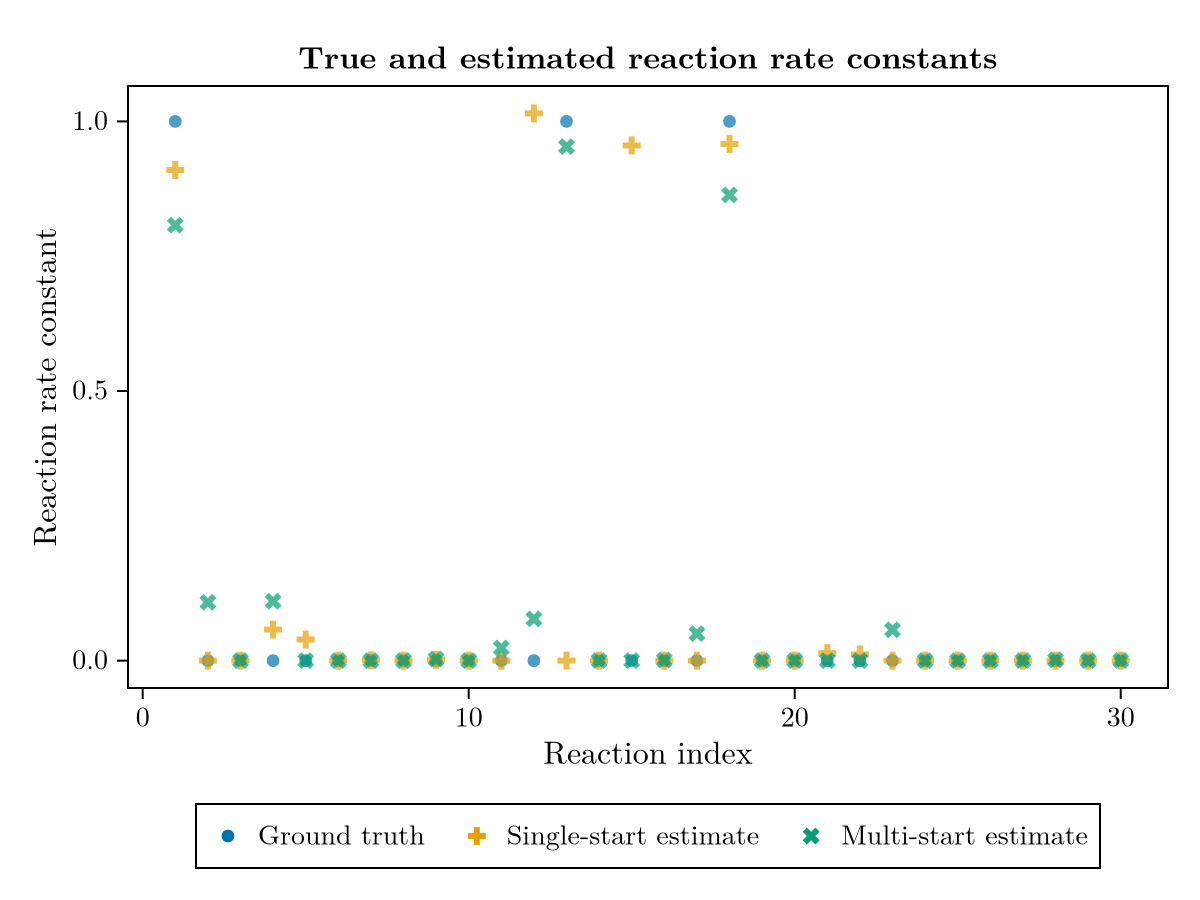

In [31]:
multistart_est_kvec = exp.(multistart_res.minimizer)

f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, est_kvec, alpha=0.7, label="Single-start estimate", marker=:cross, markersize=12)
scatter!(1:n_rx, multistart_est_kvec, alpha=0.7, label="Multi-start estimate", marker=:xcross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

Our multi-start estimation procedure strongly suggests that reactions $1$, $13$, $18$ are present in the CRN. However, it is less clear whether reactions $2$, $4$, $11$, $12$, $17$, $23$ are present in the CRN. We also note that the rate constants for the reactions in the ground-truth CRN are underestimated, an issue that we will revisit later.

### Reaction network inference

Given that visual inspection is insufficient to infer which reactions are present in the CRN, we aim to perform this inference quantitatively instead. There are multiple approaches to this requiring varying levels of computational effort (see variable selection in regression problems), here we develop a method that is rather *ad hoc* but quick-to-compute.

To get a parsimonious CRN, we sequentially include entries of the rate constant vector (from the largest values) until the model fit is similar to the model fit with all estimated constants. For this part, we quantify model fit via the loss function without any penalty function. We will say that when including a reaction results in reducing the optimised loss by less than 1, then the model fits are considered similar enough.

In [38]:
function check_parsimony(est_kvec)
    full_loss = loss_func_unknown_rx(est_kvec)
    tmp_kvec = zeros(n_rx)
    for (num, idx) in  enumerate(reverse(sortperm(est_kvec)))
        tmp_kvec[idx] = est_kvec[idx]
        loss_offset = loss_func_unknown_rx(tmp_kvec) - full_loss
        println("Number of reactions = $num, Loss offset = $loss_offset")
    end
end

check_parsimony(multistart_est_kvec)

Number of reactions = 1, Loss offset = 584065.7722678882
Number of reactions = 2, Loss offset = 642125.3268341068
Number of reactions = 3, Loss offset = 1678.6881415662895
Number of reactions = 4, Loss offset = 7277.736636345747
Number of reactions = 5, Loss offset = 16947.484347832462
Number of reactions = 6, Loss offset = 5774.853319850359
Number of reactions = 7, Loss offset = 300.3626922013948
Number of reactions = 8, Loss offset = 52.47065762693413
Number of reactions = 9, Loss offset = 279.74786062105386
Number of reactions = 10, Loss offset = 0.3238188464779057
Number of reactions = 11, Loss offset = 0.1450894871438777
Number of reactions = 12, Loss offset = 0.016926136709713546
Number of reactions = 13, Loss offset = 0.015358738913420211
Number of reactions = 14, Loss offset = 0.01017070176044399
Number of reactions = 15, Loss offset = 0.00019745630606848863
Number of reactions = 16, Loss offset = -0.00022822791129328834
Number of reactions = 17, Loss offset = -0.00024124343281

The difference in loss function is insignificant after the $9$ reactions with the largest rate constant estimates are included. The reactions that we infer to be present in the CRN are shown below. The first $3$ reactions are in the ground-truth CRN, while the other $6$ reactions are extraneous (false positives).

In [40]:
println(reverse(sortperm(multistart_est_kvec))[1:9])

[13, 18, 1, 4, 2, 12, 23, 17, 11]


### Hyperparameter tuning

At this point, one could potentially obtain a more parsimonious CRN by repeating the estimation/inference procedure with these $10$ reactions (instead of the original $30$ reactions). However, one could also obtain a more parsimonious CRN by adjusting the penalty hyperparameter $\lambda$. Here, we repeat the estimation for a $10$ values of $\lambda$, namely $\lambda = 2^j$ for $j=-3,\ldots,6$. To obtain a parsimonious CRN, we select the run with the largest value of $\lambda$ that still gives a reasonable model fit, which we again quantify via the un-penalised loss function. The following code takes a few minutes to run, as we are performing $10$ instances of multi-start optimisation.

In [34]:
λvec = 2.0 .^ (-3:6)
resvec = [];
for λval in λvec
    penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λval*sum(exp.(θ))
    @time res = multistart_optimize(penalised_func, start_pts, lower_bounds, upper_bounds, opt_args)
    push!(resvec, res)
end

 38.666730 seconds (172.57 M allocations: 10.637 GiB, 6.95% gc time, 0.30% compilation time)
 48.087797 seconds (222.12 M allocations: 13.615 GiB, 7.14% gc time, 0.27% compilation time)
 43.619331 seconds (207.50 M allocations: 12.754 GiB, 7.36% gc time, 0.41% compilation time)
 45.457663 seconds (220.50 M allocations: 13.583 GiB, 7.43% gc time, 0.25% compilation time)
 46.795707 seconds (229.25 M allocations: 14.092 GiB, 7.38% gc time, 0.23% compilation time)
 47.076437 seconds (227.50 M allocations: 14.010 GiB, 7.36% gc time, 0.29% compilation time)
 50.768089 seconds (248.11 M allocations: 15.238 GiB, 7.43% gc time, 0.21% compilation time)
 57.026101 seconds (251.14 M allocations: 15.488 GiB, 6.72% gc time, 0.20% compilation time)
 46.994510 seconds (205.35 M allocations: 12.667 GiB, 6.79% gc time, 0.29% compilation time)
 56.434400 seconds (242.62 M allocations: 14.960 GiB, 6.95% gc time, 0.21% compilation time)


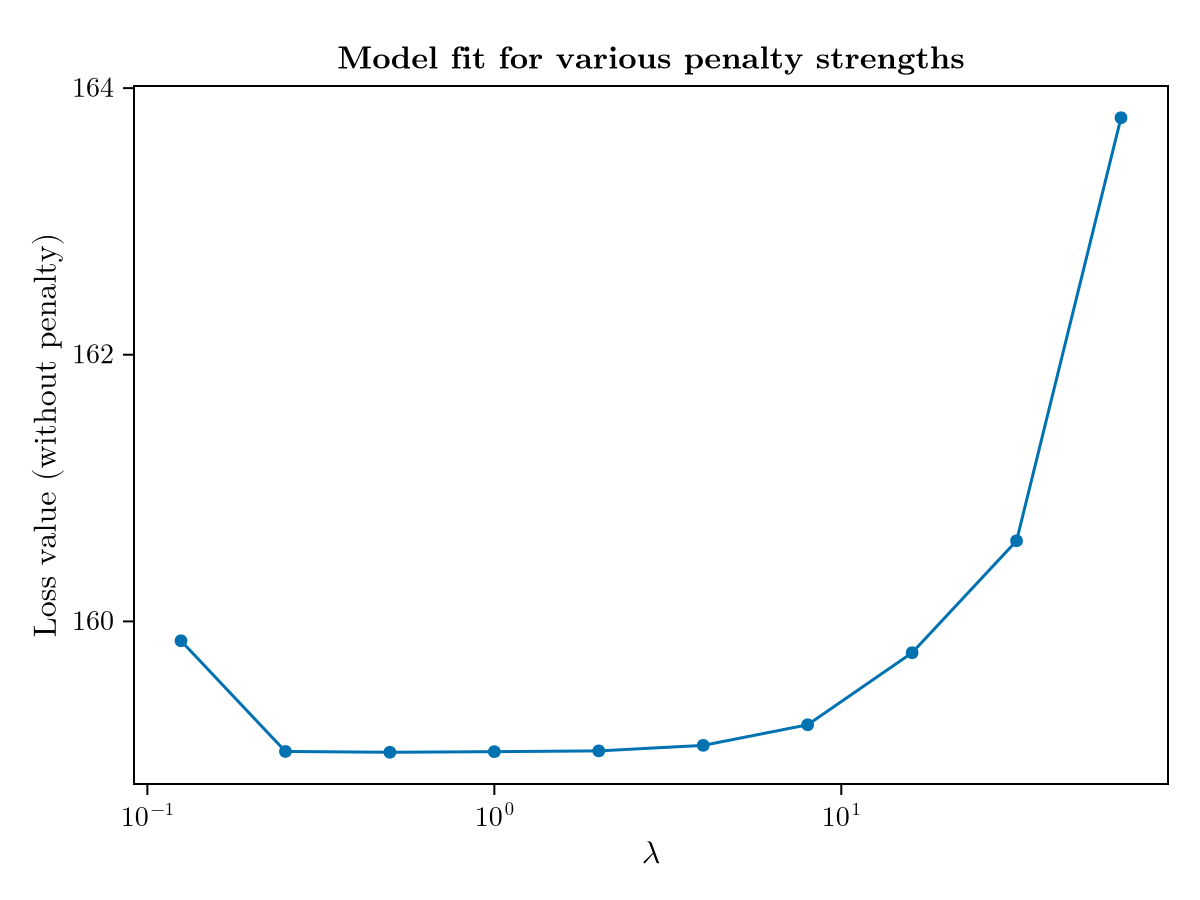

In [36]:
loss_vals = [loss_func_unknown_rx(exp.(res.minimizer)) for res in resvec]

f = Figure()
ax = Axis(f[1,1], xscale=log10, xlabel=L"$λ$", ylabel="Loss value (without penalty)", title="Model fit for various penalty strengths")
scatterlines!(λvec, loss_vals)
current_figure()

In [ ]:
function check_parsimony(est_kvec)
    full_loss = loss_func_unknown_rx(est_kvec)
    tmp_kvec = zeros(n_rx)
    for (num, idx) in  enumerate(reverse(sortperm(est_kvec)))
        tmp_kvec[idx] = est_kvec[idx]
        loss_offset = loss_func_unknown_rx(tmp_kvec) - full_loss
        println("Number of reactions = $num, Loss offset = $loss_offset")
    end
end

check_parsimony(multistart_est_kvec)

In theory, the model fit should deteriorate as penalty strength increases, as increasing the penalty results in underfitting the data. This is largely true, except for the case of $\lambda=0.125$. A likely explanation is that for this case, the multi-start optimisation procedure still returned a suboptimal solution. Random variaiton is ruled out as the cause since the same starting points are used for all values of $\lambda$. This suggests that weak penalty strength results in an optimisation landscape that is more multimodal. Out of the tested values of $\lambda$, we will proceed with the results obtained with $\lambda=16$, as the model fit is compromised for larger values of $\lambda$.

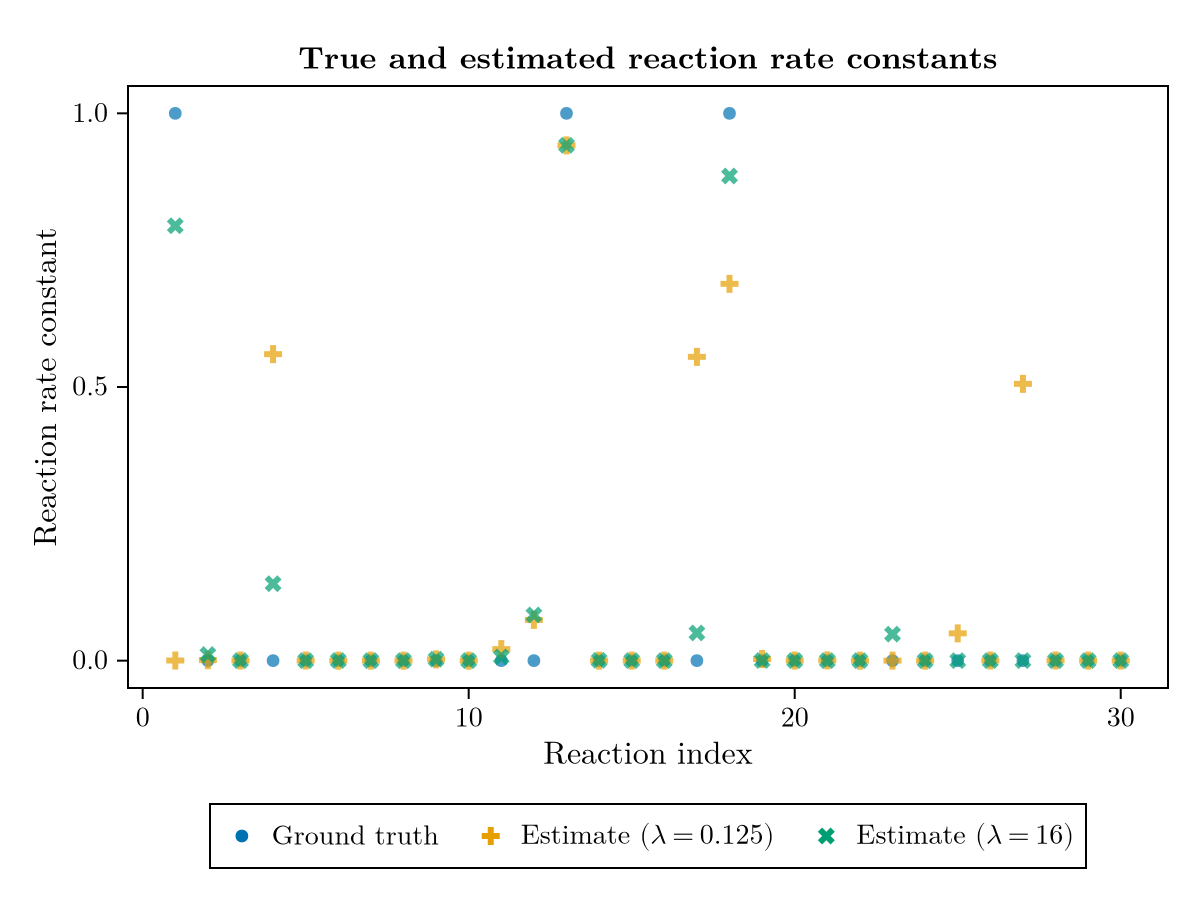

In [43]:
minλ_est_kvec = exp.(resvec[1].minimizer)
tuned_est_kvec = exp.(resvec[8].minimizer)

f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, minλ_est_kvec, alpha=0.7, label=L"Estimate $(λ=0.125)$", marker=:cross, markersize=12)
scatter!(1:n_rx, tuned_est_kvec, alpha=0.7, label=L"Estimate $(λ=16)$", marker=:xcross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

In [44]:
check_parsimony(tuned_est_kvec)

Number of reactions = 1, Loss offset = 583607.5959538287
Number of reactions = 2, Loss offset = 645929.7474438463
Number of reactions = 3, Loss offset = 2589.646693429882
Number of reactions = 4, Loss offset = 11590.546262517948
Number of reactions = 5, Loss offset = 2671.53205365468
Number of reactions = 6, Loss offset = 1174.2801589545516
Number of reactions = 7, Loss offset = 220.013407760072
Number of reactions = 8, Loss offset = 137.03047882666257
Number of reactions = 9, Loss offset = 246.73007035045973
Number of reactions = 10, Loss offset = 0.13803825660161806
Number of reactions = 11, Loss offset = 0.307133902894833
Number of reactions = 12, Loss offset = 0.39245509957342506
Number of reactions = 13, Loss offset = 0.0015946414797838315
Number of reactions = 14, Loss offset = 0.00034450150886300435
Number of reactions = 15, Loss offset = 0.000556523134832787
Number of reactions = 16, Loss offset = 0.00030093985321855143
Number of reactions = 17, Loss offset = -0.000177020841675

Note that even though $\lambda=0.125$ and $\lambda=16$ give similar loss values (without penalty), we can see that $\lambda=0.125$ gives more false positives. However, $\lambda=16$ has not given us a more parsimonious CRN than the CRN initially inferred with $\lambda=1$ (still need $9$ reactions for a good model fit).

### Alternative penalty function

The $L_1$ penalty function we have used thus far is a rather standard choice in regression, often under the name *lasso regression*. It is known to induce sparsity in coefficient estimates for linear regression, however we have not obtained sufficient sparsity for our application of CRN inference.

In this section, we explore an alternative penalty function used by [Gupta et al. (2020)](https://doi.org/10.1371/journal.pcbi.1007669). Recall that during optimisation, we constrained each rate constant $k$ between $k_\min=10^{-10}$ and $k_\max=10^{2}$. We now set the penalty function to be $\lambda \log(k/k_\min)$ for some hyperparameter $\lambda$. In other words, the penalty increases linearly with $\log k$ instead, and is $0$ for $k=k_\min$. We refer to this penalty function as the $\log L_1$ penalty. We use the same hyperparameter tuning procedure as we did with the $L_1$ penalty function.

In [47]:
alt_resvec = [];
for λval in λvec
    penalised_func(θ) = loss_func_unknown_rx(exp.(θ)) + λval*(sum(θ) .- n_rx*LB) # note θ = log k
    @time res = multistart_optimize(penalised_func, start_pts, lower_bounds, upper_bounds, opt_args)
    push!(alt_resvec, res)
end

 55.842092 seconds (268.19 M allocations: 16.575 GiB, 6.99% gc time, 0.26% compilation time)
 59.891914 seconds (293.30 M allocations: 18.094 GiB, 6.80% gc time, 0.13% compilation time)
 67.553316 seconds (333.05 M allocations: 20.616 GiB, 6.87% gc time, 0.12% compilation time)
 56.330324 seconds (280.91 M allocations: 17.409 GiB, 6.79% gc time, 0.13% compilation time)
 57.922267 seconds (290.48 M allocations: 18.031 GiB, 6.81% gc time, 0.14% compilation time)
 60.809523 seconds (297.03 M allocations: 18.470 GiB, 6.49% gc time, 0.15% compilation time)
 51.732627 seconds (258.03 M allocations: 16.023 GiB, 6.66% gc time, 0.14% compilation time)
 48.033601 seconds (242.38 M allocations: 15.043 GiB, 6.76% gc time, 0.16% compilation time)
 42.338548 seconds (206.79 M allocations: 12.864 GiB, 6.60% gc time, 0.18% compilation time)
 41.082844 seconds (186.54 M allocations: 11.559 GiB, 6.18% gc time, 0.17% compilation time)


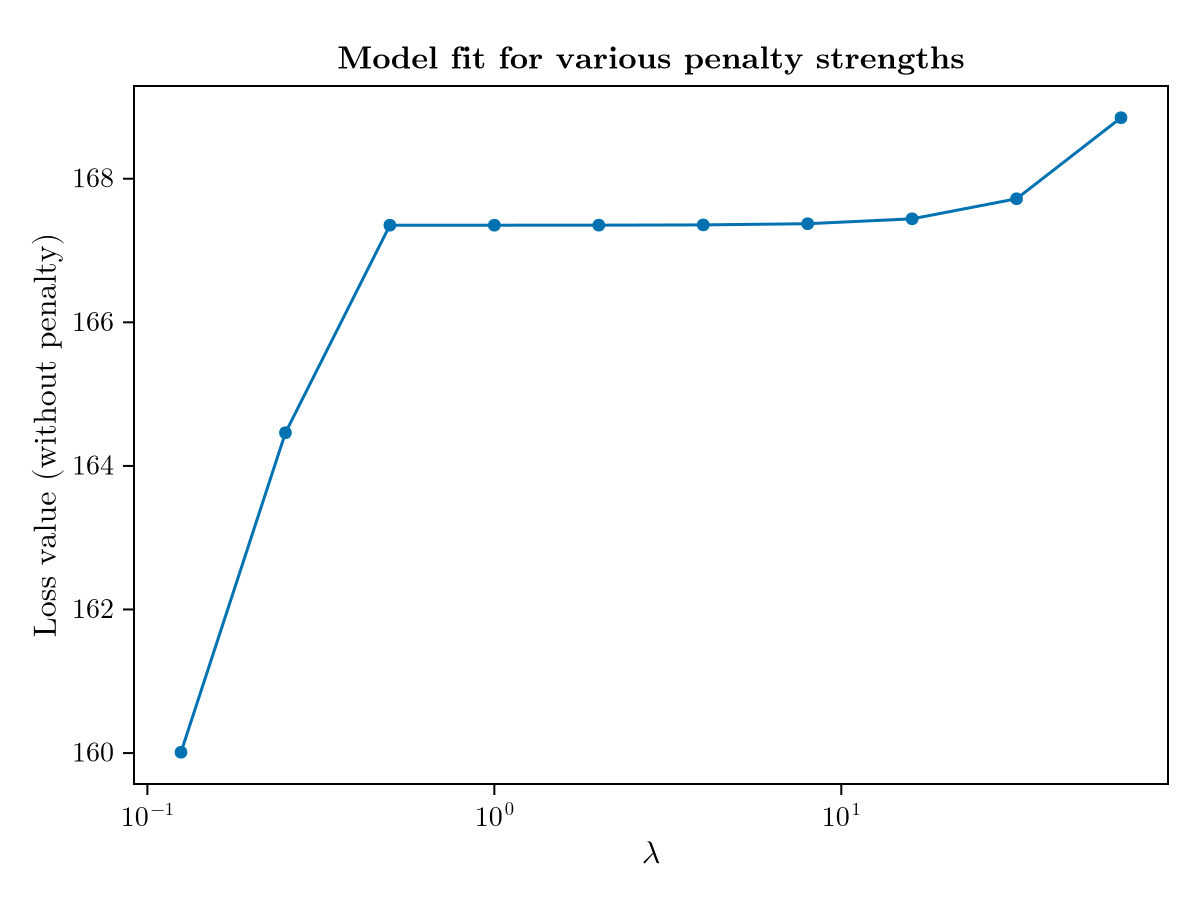

In [70]:
alt_loss_vals = [loss_func_unknown_rx(exp.(res.minimizer)) for res in alt_resvec]

f = Figure()
ax = Axis(
    f[1,1], xscale=log10, xlabel=L"$λ$", ylabel="Loss value (without penalty)", 
    title="Model fit for various penalty strengths"
)
scatterlines!(λvec, alt_loss_vals)
current_figure()

As we expect, model fit deteriorates as penalty strength increases. Yet this time there is a clear plateau from $\lambda=0.5$ to $\lambda=32$ of similar model fits. We will proceed our analysis with the results obtained with $\lambda=32$. The associated loss value $(\approx 168)$ is significantly higher than the loss value from the previous section $(\approx 160)$, signalling a relatively worse fit. However, let us look at the rate constant estimates.

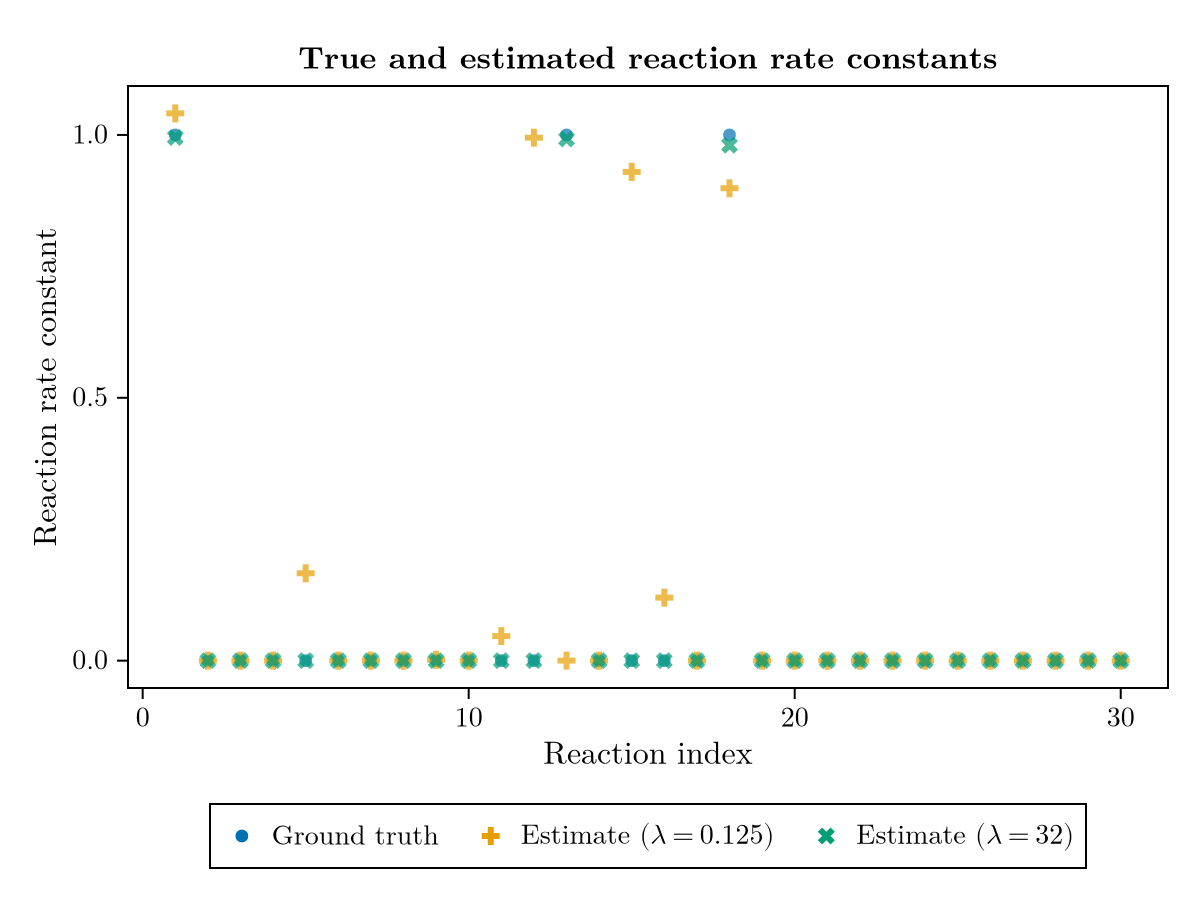

In [69]:
alt_minλ_est_kvec = exp.(alt_resvec[1].minimizer)
alt_tuned_est_kvec = exp.(alt_resvec[9].minimizer)

f = Figure()
title = "True and estimated reaction rate constants"
ax = Axis(
    f[1,1], title=title, xlabel="Reaction index", ylabel="Reaction rate constant"
)
scatter!(1:n_rx, true_kvec, alpha=0.7, label="Ground truth")
scatter!(1:n_rx, alt_minλ_est_kvec, alpha=0.7, label=L"Estimate $(λ=0.125)$", marker=:cross, markersize=12)
scatter!(1:n_rx, alt_tuned_est_kvec, alpha=0.7, label=L"Estimate $(λ=32)$", marker=:xcross, markersize=12)
f[2, 1] = Legend(f, ax, orientation=:horizontal);
current_figure()

Again, the results with the smallest value of $λ$ clearly result in overfitting (several false positives). As for the tuned case with $\lambda=32$, the rate constants of the reactions in ground truth CRN are estimated well, and we do not see any false positives visually. We check this using the same network inference procedure.

In [53]:
check_parsimony(alt_tuned_est_kvec)

Number of reactions = 1, Loss offset = 1.5749920453151485e6
Number of reactions = 2, Loss offset = 33363.57186803141
Number of reactions = 3, Loss offset = 1.8855020016417257e-6
Number of reactions = 4, Loss offset = 1.6505670998867572e-6
Number of reactions = 5, Loss offset = 1.910355194922886e-6
Number of reactions = 6, Loss offset = 1.8838920539110404e-6
Number of reactions = 7, Loss offset = 1.8655289864000224e-6
Number of reactions = 8, Loss offset = 1.7186396519264235e-6
Number of reactions = 9, Loss offset = 1.6346268125744245e-6
Number of reactions = 10, Loss offset = 1.307712608422662e-6
Number of reactions = 11, Loss offset = 1.1700786899382365e-6
Number of reactions = 12, Loss offset = 1.2465881980006088e-6
Number of reactions = 13, Loss offset = 1.2329199989835615e-6
Number of reactions = 14, Loss offset = 1.1876454379944335e-6
Number of reactions = 15, Loss offset = 1.1183834089933953e-6
Number of reactions = 16, Loss offset = 8.336236021477816e-7
Number of reactions = 17,

Clearly, only 3 reactions, i.e. reactions $1$, $3$, $18$, are needed for a parsimonious CRN.

In [73]:
reverse(sortperm(alt_tuned_est_kvec))[1:3]

3-element Vector{Int64}:
  1
 13
 18

Why did changing the penalty function have such a dramatic effect? One possible answer comes from interpreting a penalty function as the negative log density of a prior distribution on the rate constants. Since most reactions in the library CRN are not present in the ground-truth CRN, their rate constants (regardless of whether the reactions are truly present) follow an extreme-value distribution. The $L_1$ penalty corresponds to an exponential prior, while the $\log L_1$ penalty corresponds to a prior with a power-law density. The tail of a power-law distribution is heavier than an exponential tail, making it more suitable for describing an extreme-value distribution.